In [1]:
# For operating system interaction
import os
import glob
import datetime
import sys

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special

# Library to perform MCMC sampling
import emcee

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner
mwc.set_plotting_style()
from collections import OrderedDict

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Generate a variable with the day that the script is run
today = str(datetime.datetime.today().strftime('%Y%m%d'))

# Plotting of DNA/Inducer Mutants

Lets start by plotting the data from the individual mutants. We will lot at both, the fits from the individual inducer or DNA mutant fits, and later using the global fit analysis. To begin, we can load in the fold-change data.

In [13]:
# Load all of the 2018 flow data.
flow_files = glob.glob('../../../processing/2018*flow*/output/*fold_change.csv')
dfs = [pd.read_csv(f, comment='#') for f in flow_files]
flow_data = pd.concat(dfs, axis=0)
flow_data = flow_data[(flow_data['fold_change'] >= -0.2) & (flow_data['fold_change'] <= 1.3)]

# Load the microscopy data
mic_files = glob.glob('../../../processing/2018*microscopy*/output/*fold_change.csv')
dfs = [pd.read_csv(f) for f in mic_files]
mic_data = pd.concat(dfs, axis=0)
mic_data['IPTGuM'] = 0.0

df = pd.concat([flow_data, mic_data], ignore_index=True)
df = df[df.mutant != 'Q294R']

# Now we remove the autofluorescence and delta values
df = df[(df.mutant != 'auto') & (df.mutant != 'delta') & (df.operator == 'O2')]

# Restart index
df = df.reset_index()

# not going to bother with those containing Q294K yet
df.head()

# only want R=260 for now
# df = df[df.strain=='R260']

,index,IPTGuM,Unnamed: 0,date,fold_change,mean_FITC_H,mean_YFP,mutant,operator,repressors,run_number,strain,username
0,2,0.0,2.0,20180409,-0.004128,5209.473763,NaN,wt,O2,260.0,NaN,R260,nbellive
1,3,0.0,3.0,20180409,-0.005374,5186.974267,NaN,Q294V,O2,260.0,NaN,R260,nbellive
2,4,0.0,4.0,20180409,0.002297,5325.494040,NaN,F164T,O2,260.0,NaN,R260,nbellive
3,7,0.1,7.0,20180409,0.012561,5187.629503,NaN,wt,O2,260.0,NaN,R260,nbellive
4,8,0.1,8.0,20180409,0.005620,5060.321179,NaN,Q294V,O2,260.0,NaN,R260,nbellive


Lets begin by considering the DNA mutant fits from only the IPTG=0 $\mu$M cocentration.

In [3]:
param_fit_DNA_rbsonly = pd.read_csv('param_fit_DNA_rbsonly.csv', index_col=0)

map_DNA_rbs = param_fit_DNA_rbsonly['mode'].to_dict()

In [4]:
map_DNA_rbs

{'1220.0': 1221.009432822969,
 '124.0': 121.99810275609272,
 '260.0': 262.59333260487847,
 '60.0': 58.57279367244913,
 'Ka': 204.672822384188,
 'Ki': 0.7326899787168117,
 'Q21A_eps': -9.579945073758099,
 'Q21M_eps': -24.161626635527874,
 'Y20I_eps': -8.992665931873534,
 'ka': -5.321412715822442,
 'ki': 0.31103261510804425,
 'sigma': 0.07500793466615893,
 'wt_eps': -13.588067108175693}

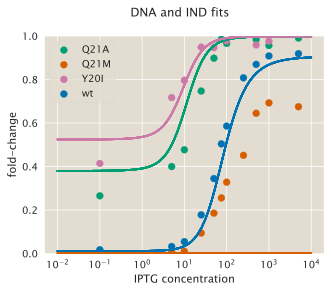

In [6]:
# we have DNA mutants, and we have inducer mutants 
# single O2 operator, plot as a function of IPTG concentration
DNAmut_list = ['wt', 'Q21A', 'Q21M', 'Y20I']
INDmut_list = ['wt', 'Q294V', 'F164T', 'Q294R']

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

mut_list = {'wt':0, 'Q21A':1, 'Q21M':2, 'Y20I':3, 'Q294V':4, 'F164T':5, 'Q294R':6}

# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-8, -2, 75)

fig, (ax1) = plt.subplots(1,1, figsize=(5, 4))
fig.suptitle('DNA and IND fits')

df_group = df.groupby(['mutant', 'IPTGuM'])

# DNA mutants
for i, data in df_group:
    if i[0] in DNAmut_list:
        ax1.scatter(i[1], data.fold_change.mean(), label=i[0], 
                    color = colors[mut_list[i[0]]])

        # plot the theory using the parameters from the fit.
        ax1.plot(IPTG * 1E6, mwc.fold_change_log(IPTG * 1E6, 
            ea=map_DNA_rbs['ka'], ei=map_DNA_rbs['ki'], epsilon=4.5,
            R=260.0*np.ones(len(IPTG)),
            epsilon_r=map_DNA_rbs[i[0]+'_eps']),
            color = colors[mut_list[i[0]]]) 
        
ax1.set_ylim(0,1)  
ax1.set_xscale('log')
ax1.set_xlabel('IPTG concentration')
ax1.set_ylabel('fold-change')


# for plotting the legend (removing replicate labels)
from collections import OrderedDict
handles, labels = ax1.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys())


Looks like the binding energy for Q21M is predicted to be very strong; and so there isn't really an IPTG response. Will need to look into this further.

Okay, now lets move on to our fits using all the data (rbs strains and IPTG titration). Lets also load in the MAP parameter values from the MCMC analysis.

In [7]:
param_fit_DNA = pd.read_csv('param_fit_DNA.csv', index_col=0)
param_fit_IND = pd.read_csv('param_fit_IND.csv', index_col=0)

map_param_DNA = param_fit_DNA['mode'].to_dict()
map_param_IND = param_fit_IND['mode'].to_dict()

In [8]:
param_fit_DNA

,mode,hpd_min,hpd_max
ka,-5.300823,0.046703,0.009165
ki,0.322913,0.026448,0.025954
sigma,0.080530,0.000824,0.006293
60.0,58.538626,0.120945,2.583496
124.0,124.219520,3.080489,0.944388
260.0,260.074977,1.894351,1.819182
1220.0,1216.583830,7.060111,15.300755
Q21A_eps,-9.766554,0.092989,0.072373
Q21M_eps,-14.589517,0.135420,0.044975
Y20I_eps,-8.982676,0.082051,0.088133


Okay, we can now take a look at the data!

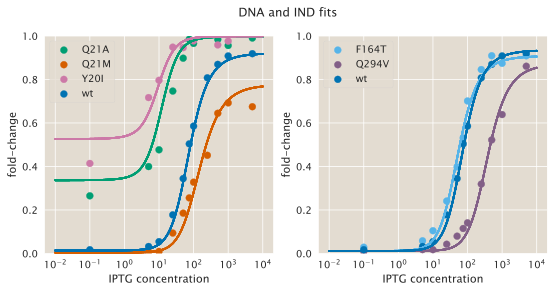

In [9]:
 # we have DNA mutants, and we have inducer mutants 
# single O2 operator, plot as a function of IPTG concentration
DNAmut_list = ['wt', 'Q21A', 'Q21M', 'Y20I']
INDmut_list = ['wt', 'Q294V', 'F164T', 'Q294R']

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

mut_list = {'wt':0, 'Q21A':1, 'Q21M':2, 'Y20I':3, 'Q294V':4, 'F164T':5, 'Q294R':6}

# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-8, -2, 75)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 4))
fig.suptitle('DNA and IND fits')

df_group = df.groupby(['mutant', 'IPTGuM'])

# DNA mutants
for i, data in df_group:
    if i[0] in DNAmut_list:
        ax1.scatter(i[1], data.fold_change.mean(), label=i[0], 
                    color = colors[mut_list[i[0]]])

        # plot the theory using the parameters from the fit.
        ax1.plot(IPTG * 1E6, mwc.fold_change_log(IPTG * 1E6, 
            ea=map_param_DNA['ka'], ei=map_param_DNA['ki'], epsilon=4.5,
            R=260.0*np.ones(len(IPTG)),
            epsilon_r=map_param_DNA[i[0]+'_eps']),
            color = colors[mut_list[i[0]]])   
ax1.set_ylim(0,1)  
ax1.set_xscale('log')
ax1.set_xlabel('IPTG concentration')
ax1.set_ylabel('fold-change')

# IND mutants
for i, data in df_group:
    if i[0] in INDmut_list:
        ax2.scatter(i[1], data.fold_change.mean(), label=i[0], 
                    color = colors[mut_list[i[0]]])

        # plot the theory using the parameters from the fit.
        ax2.plot(IPTG * 1E6, mwc.fold_change_log(IPTG * 1E6, 
            ea=map_param_IND[i[0]+'_ka'], ei=map_param_IND[i[0]+'_ki'], epsilon=4.5,
            R=260.0*np.ones(len(IPTG)),
            epsilon_r=map_param_IND['eps']),
            color = colors[mut_list[i[0]]])   
        

ax2.set_ylim(0,1)
ax2.set_xscale('log')
ax2.set_xlabel('IPTG concentration')
ax2.set_ylabel('fold-change')

# for plotting the legend (removing replicate labels)
from collections import OrderedDict
handles, labels = ax1.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys())

handles, labels = ax2.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax2.legend(by_label.values(), by_label.keys())


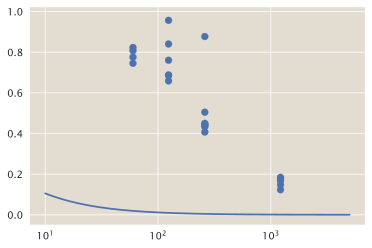

In [17]:
df_trim = df[(df.IPTGuM==0.0) & (df.mutant=='Y20I')]

rep_cn = df_trim.repressors
fold_change = df_trim.fold_change
rep = np.arange(10,5000)
fold_change_pred = (1 + 2 * rep / 4.6E6 *(1 + np.exp(-4.5)) * np.exp(14.474))**-1


plt.scatter(rep_cn, fold_change)
plt.xscale('log')
# plt.yscale('log')
plt.plot(rep, fold_change_pred) 

We can also look at how well the global fits perform against the data.

In [5]:
param_fit_globalB = pd.read_csv('param_fit_globalB.csv', index_col=0)
map_param_globalB = param_fit_globalB['mode'].to_dict()

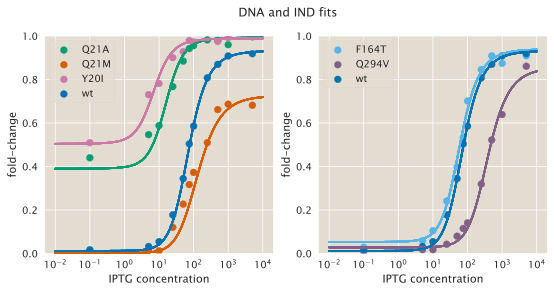

In [6]:
 # we have DNA mutants, and we have inducer mutants 
# single O2 operator, plot as a function of IPTG concentration
DNAmut_list = ['wt', 'Q21A', 'Q21M', 'Y20I']
INDmut_list = ['wt', 'Q294V', 'F164T', 'Q294R']

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

mut_list = {'wt':0, 'Q21A':1, 'Q21M':2, 'Y20I':3, 'Q294V':4, 'F164T':5, 'Q294R':6}

# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-8, -2, 75)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 4))
fig.suptitle('DNA and IND fits')

df_group = df.groupby(['mutant', 'IPTGuM'])

# DNA mutants
for i, data in df_group:
    if i[0] in DNAmut_list:
        ax1.scatter(i[1], data.fold_change.mean(), label=i[0], 
                    color = colors[mut_list[i[0]]])

        # plot the theory using the parameters from the fit.
        ax1.plot(IPTG * 1E6, mwc.fold_change_log(IPTG * 1E6, 
            ea=map_param_globalB[i[0]+'_ka'], ei=map_param_globalB[i[0]+'_ki'], 
            epsilon=4.5, R=260.0*np.ones(len(IPTG)),
            epsilon_r=map_param_globalB[i[0]+'_eps']),
            color = colors[mut_list[i[0]]])   
ax1.set_ylim(0,1)  
ax1.set_xscale('log')
ax1.set_xlabel('IPTG concentration')
ax1.set_ylabel('fold-change')

# IND mutants
for i, data in df_group:
    if i[0] in INDmut_list:
        ax2.scatter(i[1], data.fold_change.mean(), label=i[0], 
                    color = colors[mut_list[i[0]]])

        # plot the theory using the parameters from the fit.
        ax2.plot(IPTG * 1E6, mwc.fold_change_log(IPTG * 1E6, 
            ea=map_param_globalB[i[0]+'_ka'], ei=map_param_globalB[i[0]+'_ki'], 
            epsilon=4.5, R=260.0*np.ones(len(IPTG)),
            epsilon_r=map_param_globalB[i[0]+'_eps']),
            color = colors[mut_list[i[0]]])   
        

ax2.set_ylim(0,1)
ax2.set_xscale('log')
ax2.set_xlabel('IPTG concentration')
ax2.set_ylabel('fold-change')

# for plotting the legend (removing replicate labels)
from collections import OrderedDict
handles, labels = ax1.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys())

handles, labels = ax2.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax2.legend(by_label.values(), by_label.keys())


Okay, now lets take a look at how the double mutant data compares with the predictions when we take the DNA mutant's DNA binding energy, and the inducer mutant's Ka and Ki. Note that we can't really do anything using the global fits to each individual mutant strain. 

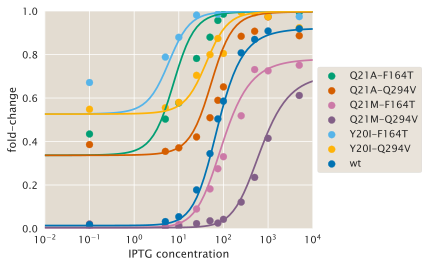

In [8]:
# for DNA mutants we will use new eps_r, but wt Ka and Ki
# for IND mutants we will use wt eps_r, but new Ka and Ki

colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]
colors[6] = sns.xkcd_palette(['amber'])[0]

# assign color to mutant
mut_dict = {'wt':0, 
            'Q21A-F164T':1, 'Q21A-Q294V':2,
            'Q21M-F164T':3, 'Q21M-Q294V':4,
            'Y20I-F164T':5, 'Y20I-Q294V':6}
mut_list =['wt', 
            'Q21A-F164T', 'Q21A-Q294V',
            'Q21M-F164T', 'Q21M-Q294V',
            'Y20I-F164T', 'Y20I-Q294V']

IPTG = np.logspace(-8,-2,75)

fig, ax = plt.subplots(1)

df_grouped = df.groupby(['mutant', 'IPTGuM'])

for i, data in df_grouped:
    if i[0] in mut_list:
        plt.scatter(i[1], data.fold_change.mean(), 
                    label=i[0], color=colors[mut_dict[i[0]]])

df_grouped_mut = df.groupby('mutant')
for mut, data in df_grouped_mut:
    if mut in mut_list:
        if mut == 'wt':
            ax.plot(IPTG * 1E6, mwc.fold_change_log(IPTG * 1E6, 
                ea=map_param_DNA['ka'], ei=map_param_DNA['ki'], epsilon=4.5,
                R=260.0*np.ones(len(IPTG)),
                epsilon_r=map_param_DNA[mut +'_eps']),
                color = colors[mut_dict[mut]])  
        if mut == 'Q21A-F164T':
            ax.plot(IPTG * 1E6, mwc.fold_change_log(IPTG * 1E6, 
                ea=map_param_IND['F164T_ka'], ei=map_param_IND['F164T_ki'], epsilon=4.5,
                R=260.0*np.ones(len(IPTG)),
                epsilon_r=map_param_DNA['Q21A_eps']),
                color = colors[mut_dict[mut]])
        if mut == 'Q21A-Q294V':
            ax.plot(IPTG * 1E6, mwc.fold_change_log(IPTG * 1E6, 
                ea=map_param_IND['Q294V_ka'], ei=map_param_IND['Q294V_ki'], epsilon=4.5,
                R=260.0*np.ones(len(IPTG)),
                epsilon_r=map_param_DNA['Q21A_eps']),
                color = colors[mut_dict[mut]])
        if mut == 'Q21M-F164T':
            ax.plot(IPTG * 1E6, mwc.fold_change_log(IPTG * 1E6, 
                ea=map_param_IND['F164T_ka'], ei=map_param_IND['F164T_ki'], epsilon=4.5,
                R=260.0*np.ones(len(IPTG)),
                epsilon_r=map_param_DNA['Q21M_eps']),
                color = colors[mut_dict[mut]])
        if mut == 'Q21M-Q294V':
            ax.plot(IPTG * 1E6, mwc.fold_change_log(IPTG * 1E6, 
                ea=map_param_IND['Q294V_ka'], ei=map_param_IND['Q294V_ki'], epsilon=4.5,
                R=260.0*np.ones(len(IPTG)),
                epsilon_r=map_param_DNA['Q21M_eps']),
                color = colors[mut_dict[mut]])
        if mut == 'Y20I-F164T':
            ax.plot(IPTG * 1E6, mwc.fold_change_log(IPTG * 1E6, 
                ea=map_param_IND['F164T_ka'], ei=map_param_IND['F164T_ki'], epsilon=4.5,
                R=260.0*np.ones(len(IPTG)),
                epsilon_r=map_param_DNA['Y20I_eps']),
                color = colors[mut_dict[mut]])
        if mut == 'Y20I-Q294V':
            ax.plot(IPTG * 1E6, mwc.fold_change_log(IPTG * 1E6, 
                ea=map_param_IND['Q294V_ka'], ei=map_param_IND['Q294V_ki'], epsilon=4.5,
                R=260.0*np.ones(len(IPTG)),
                epsilon_r=map_param_DNA['Y20I_eps']),
                color = colors[mut_dict[mut]])

ax.set_xlabel('IPTG concentration')
ax.set_ylabel('fold-change')
ax.set_xscale('log')
ax.set_xlim(10**-2,10**4)
ax.set_ylim(0,1)


# place legend on outside of plot - shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# for plotting the legend (removing replicate labels)
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig('20180428_dbl_mutants_prelim.pdf')

Now lets compare these predictions with those from the double mutant fits (where we consider each double mutant as essentially a new strain).

In [10]:
param_fit_dbl = pd.read_csv('param_fit_dbl.csv', index_col=0)
map_param_dbl = param_fit_dbl['mode'].to_dict()

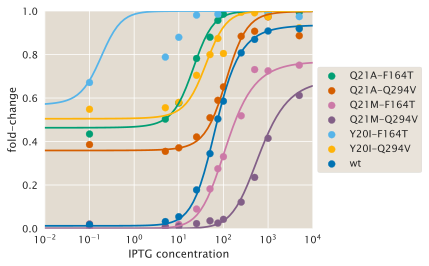

In [12]:
# for DNA mutants we will use new eps_r, but wt Ka and Ki
# for IND mutants we will use wt eps_r, but new Ka and Ki

colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]
colors[6] = sns.xkcd_palette(['amber'])[0]

# assign color to mutant
mut_dict = {'wt':0, 
            'Q21A-F164T':1, 'Q21A-Q294V':2,
            'Q21M-F164T':3, 'Q21M-Q294V':4,
            'Y20I-F164T':5, 'Y20I-Q294V':6}
mut_list =['wt', 
            'Q21A-F164T', 'Q21A-Q294V',
            'Q21M-F164T', 'Q21M-Q294V',
            'Y20I-F164T', 'Y20I-Q294V']

IPTG = np.logspace(-8,-2,75)

fig, ax = plt.subplots(1)

df_grouped = df.groupby(['mutant', 'IPTGuM'])

for i, data in df_grouped:
    if i[0] in mut_list:
        plt.scatter(i[1], data.fold_change.mean(), 
                    label=i[0], color=colors[mut_dict[i[0]]])

df_grouped_mut = df.groupby('mutant')
for mut, data in df_grouped_mut:
    if mut in mut_list:
        ax.plot(IPTG * 1E6, mwc.fold_change_log(IPTG * 1E6, 
            ea=map_param_dbl[mut + '_ka'], ei=map_param_dbl[mut + '_ki'], epsilon=4.5,
            R=260.0*np.ones(len(IPTG)),
            epsilon_r=map_param_dbl[mut +'_eps']),
            color = colors[mut_dict[mut]])  

ax.set_xlabel('IPTG concentration')
ax.set_ylabel('fold-change')
ax.set_xscale('log')
ax.set_xlim(10**-2,10**4)
ax.set_ylim(0,1)


# place legend on outside of plot - shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# for plotting the legend (removing replicate labels)
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig('20180428_dbl_mutants_prelim.pdf')